In [1]:
model_path_1 = "experiments/yolo_nas_s_cppe-5/RUN_20250821_125336_088773/ckpt_best.pth"

In [2]:
model_path_2 = "experiments/yolo_nas_s_cppe-5_qat/yolo_nas_s_cppe-5_qat_1x3x640x640_qat.onnx" 

In [3]:
NUM_CLASSES = 5

In [4]:
import torch
from super_gradients.common.object_names import Models
from super_gradients.training import models

model = models.get(Models.YOLO_NAS_S, num_classes=NUM_CLASSES, checkpoint_path=model_path_1)
model.num_classes

5

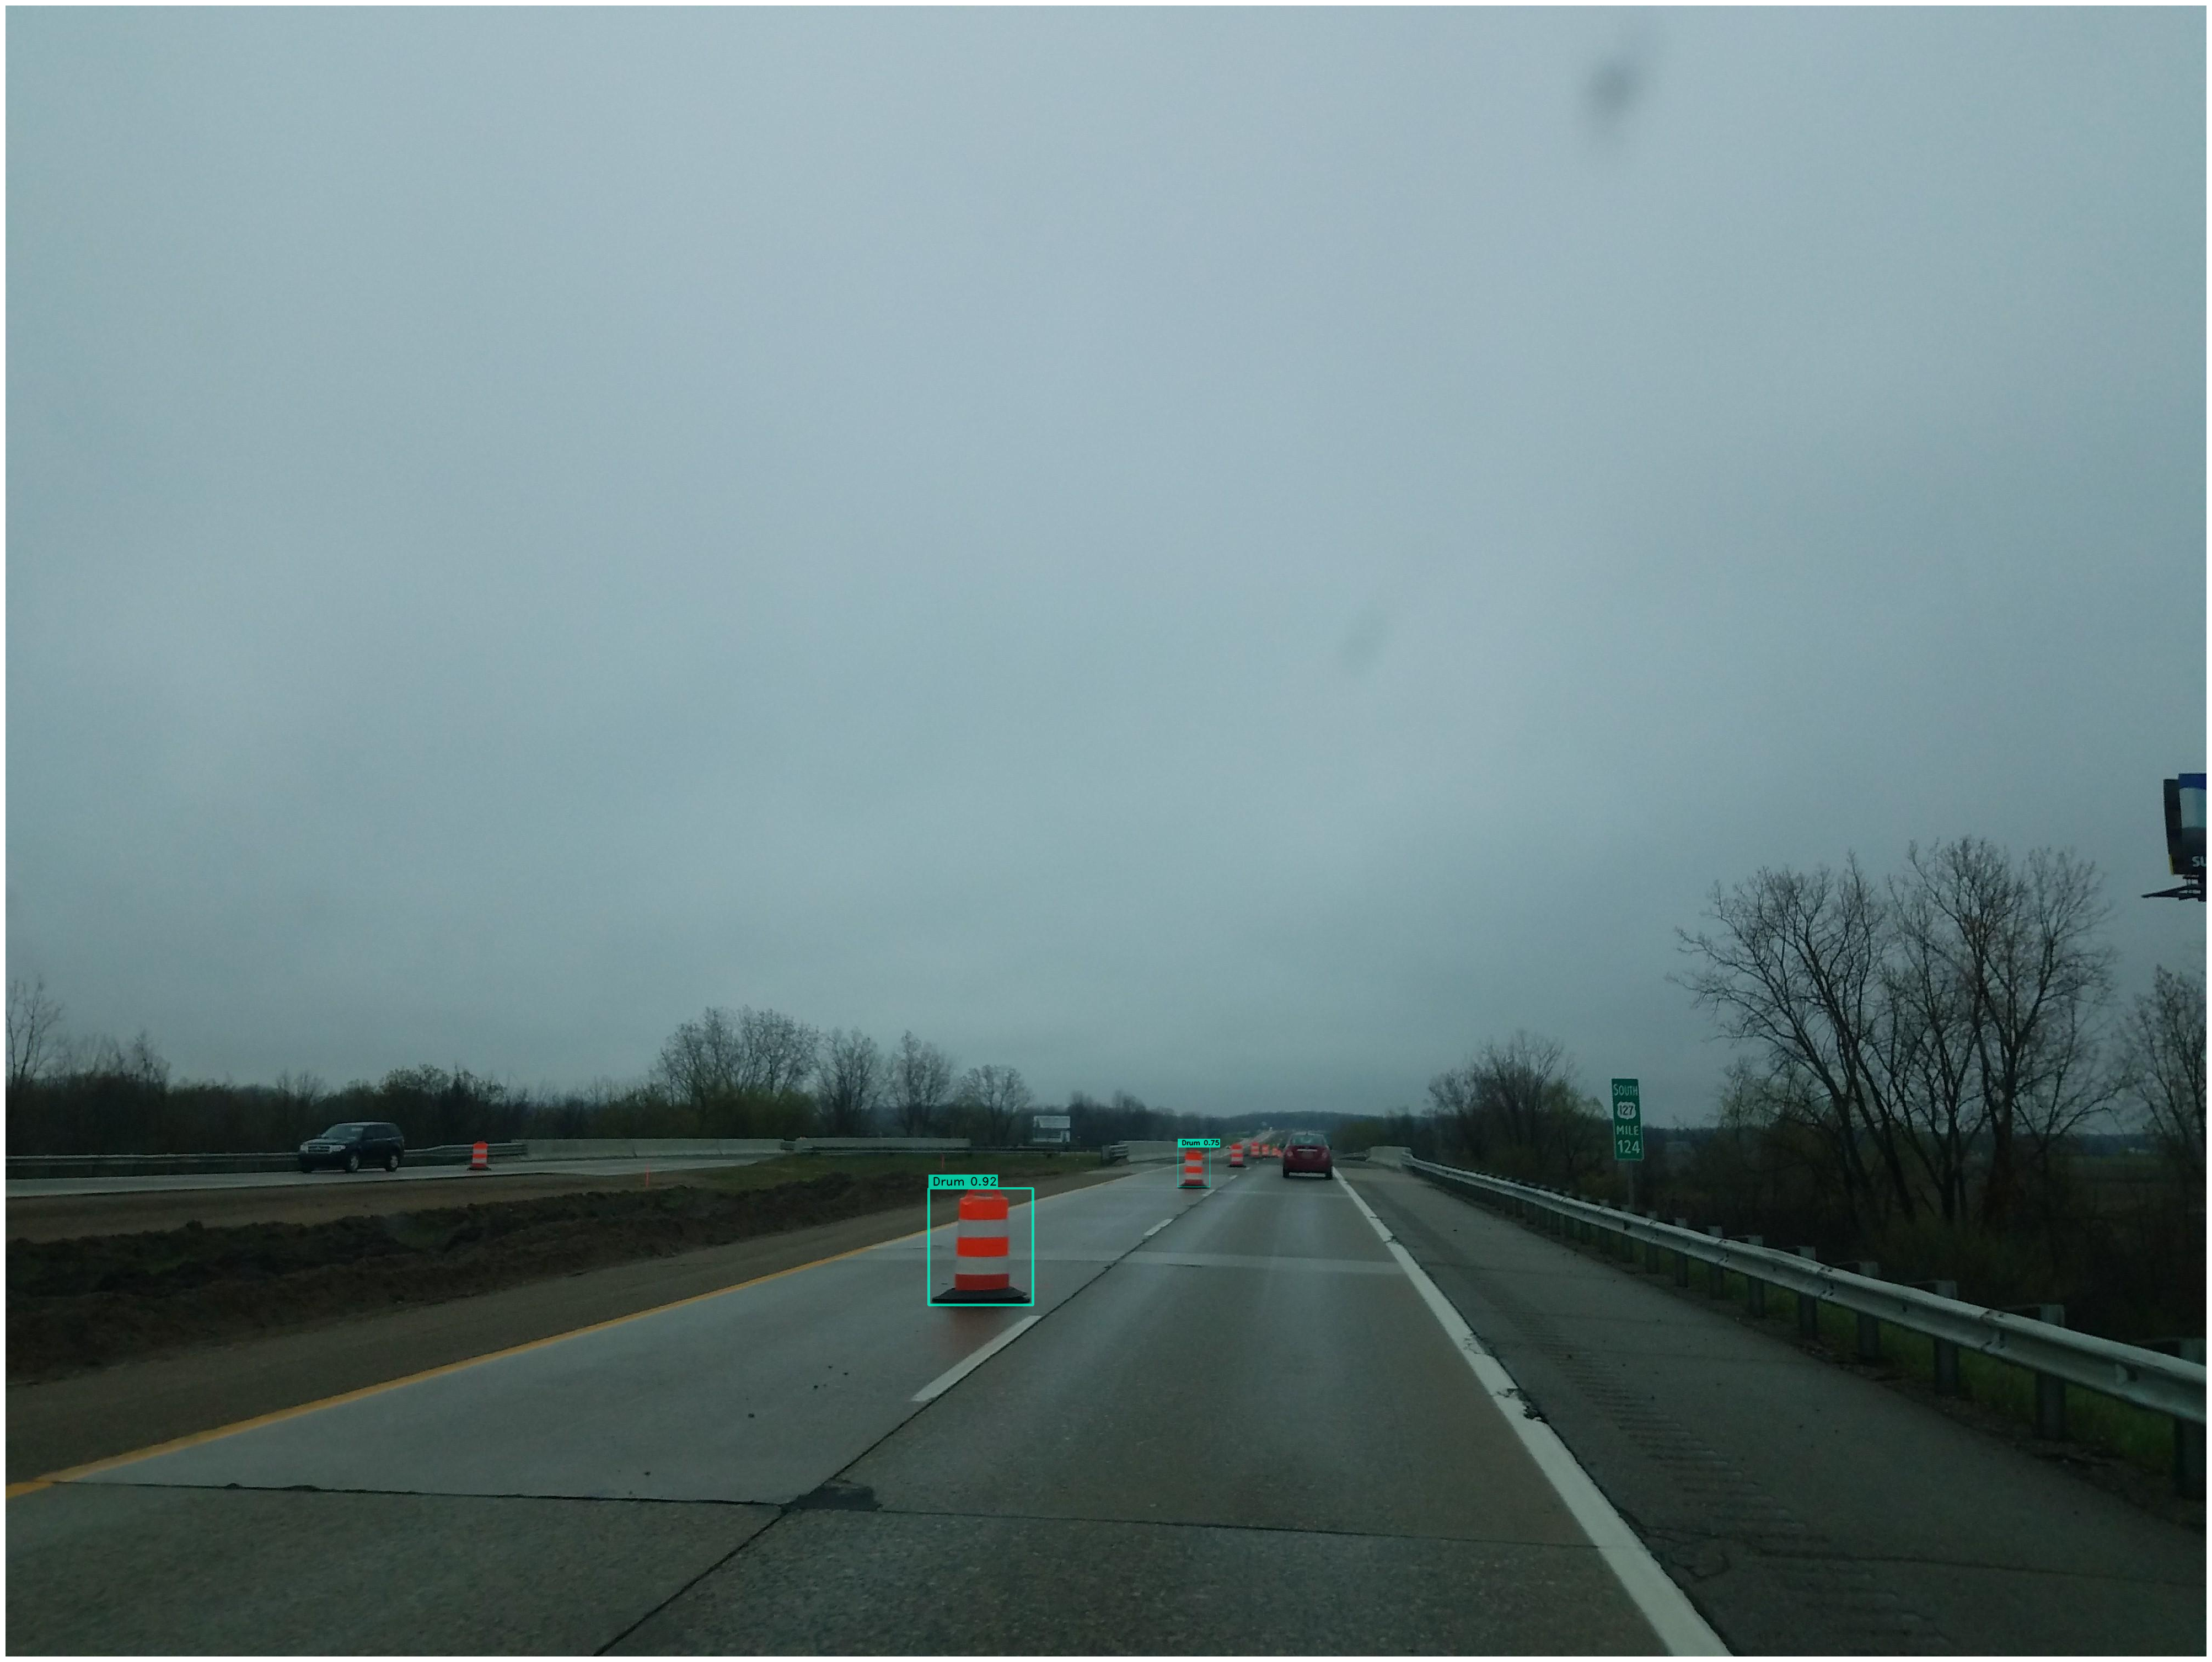

In [5]:
prediction = model.predict("abc.jpg", fuse_model=False)
prediction.show()

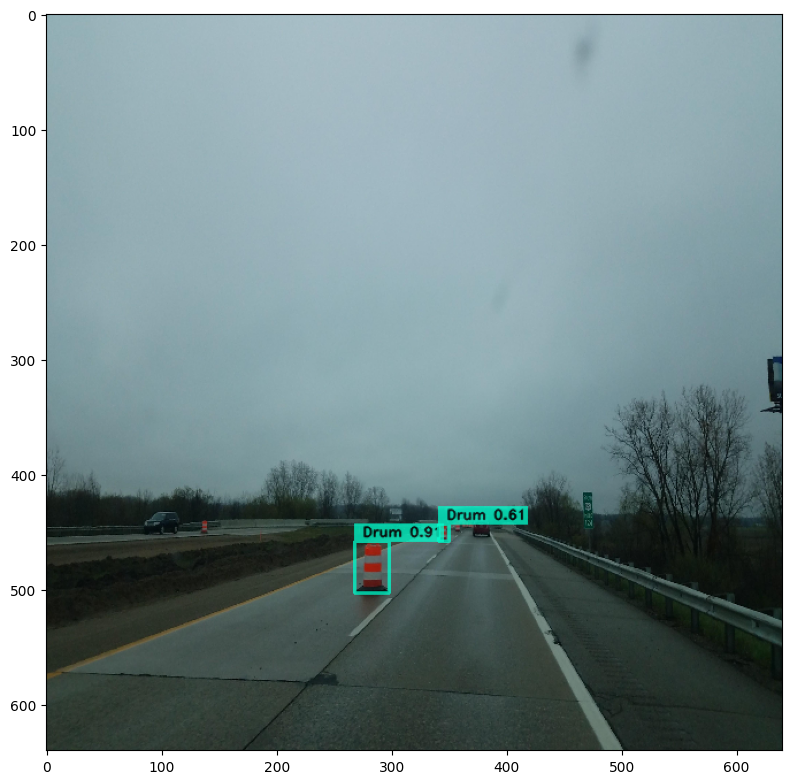

In [6]:
import cv2

CLASS_NAMES = ["Cone", "Drum", "Vertical Panel", "Tubular Marker", "Arrow Board"]

from super_gradients.training.utils.detection_utils import DetectionVisualization
from super_gradients.training.utils.media.image import load_image
import onnxruntime
import numpy as np

import matplotlib.pyplot as plt
from super_gradients.inference import iterate_over_detection_predictions_in_batched_format


def show_predictions_from_batch_format(image, predictions):
    image_index, pred_boxes, pred_scores, pred_classes = next(iter(iterate_over_detection_predictions_in_batched_format(predictions)))

    predicted_boxes = np.concatenate([pred_boxes, pred_scores[:, np.newaxis], pred_classes[:, np.newaxis]], axis=1)

    image = DetectionVisualization.visualize_image(image_np=np.array(image), class_names=CLASS_NAMES, pred_boxes=predicted_boxes)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.tight_layout()
    plt.show()


session = onnxruntime.InferenceSession(model_path_2, providers=["CUDAExecutionProvider", "CPUExecutionProvider"])
inputs = [o.name for o in session.get_inputs()]
outputs = [o.name for o in session.get_outputs()]

image_onnx = load_image("abc.jpg")
image_onnx = cv2.resize(image_onnx, (640, 640))

input_image_onnx = np.moveaxis(image_onnx, -1, 0)
input_image_onnx = np.expand_dims(input_image_onnx, axis=0)
predictions_onnx = session.run(outputs, {inputs[0]: input_image_onnx})

show_predictions_from_batch_format(image_onnx, predictions_onnx)